In [1]:
!cp ../input/talibinstall/ta-lib-0.4.0-src.tar.gzh  ./ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz > null
!cd ta-lib && ./configure --prefix=/usr > null && make  > null && make install > null
!cp ../input/talibinstall/TA-Lib-0.4.21.tar.gzh TA-Lib-0.4.21.tar.gz
!pip install TA-Lib-0.4.21.tar.gz > null
!pip install ../input/talibinstall/numpy-1.21.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl >null

!rm -rf ./ta-lib
!rm  ./TA-Lib-0.4.21.tar.gz
!rm  ./ta-lib-0.4.0-src.tar.gz
!rm  ./null

import talib as ta

./configure: line 4349: /usr/bin/file: No such file or directory
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
gen_code.c: In function ‘printFuncHeaderDoc’:
gen_code.c:3456:4: warning: format not a string literal and no format arguments [-Wformat-security]
 3456 |    fprintf( out, prefix );
      |    ^~~~~~~
ERROR: pip's dependency resolver does not currently take into a

In [2]:
import os, gc, warnings, random, datetime, traceback, joblib
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
import numpy.polynomial.hermite as Herm
import math
import tensorflow_probability as tfp

from tensorflow.keras import regularizers
from sklearn.preprocessing import RobustScaler
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

In [3]:
path_s = "../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/"
path_t = "../input/jpx-tokyo-stock-exchange-prediction/train_files/"
path_e = "../input/jpx-tokyo-stock-exchange-prediction/example_test_files/"

In [4]:
prices1 = pd.read_csv(f"{path_s}stock_prices.csv") #2021
prices2 = pd.read_csv(f"{path_t}stock_prices.csv") #2017
prices3 = pd.read_csv(f"{path_t}secondary_stock_prices.csv")

prices1.shape , prices2.shape, prices3.shape

((229958, 12), (2332531, 12), (2384575, 12))

In [5]:
prices2['Target'].isnull().sum(), prices1['Target'].isnull().sum(), prices3['Target'].isnull().sum()

(238, 6, 718)

In [6]:
train2 = prices2.dropna(subset=['Target'])
train1 = prices1.dropna(subset=['Target'])

In [7]:
train2['Target'].isnull().sum(), train1['Target'].isnull().sum()

(0, 0)

In [8]:
df = pd.concat([train2,train1])

In [9]:
device = "GPU" 

In [10]:
if device == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu)
            print("TPU initialized")
        except: print("failed to initialize TPU")
    else: device = "GPU"

if device != "TPU": strategy = tf.distribute.get_strategy()
if device == "GPU": print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

Num GPUs Available:  1


2022-06-14 06:09:48.138458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 06:09:48.226692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 06:09:48.227460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [11]:
def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

In [12]:
SEED = 2022
set_all_seeds(SEED)

In [13]:
class Config:
    is_training = True
    output_dataset_path = "../input/models-for-jpx-aemlp-tf/"
config = Config()

In [14]:
%%time
securities_codes = pd.read_csv("../input/jpx-cgkf-f98-tf/securities_codes.csv")
securities_codes_size = len(securities_codes) + 1
with tf.device("cpu"):
    securities_codes_lookup_layer = layers.IntegerLookup(max_tokens=securities_codes_size)
    securities_codes_lookup_layer.adapt(securities_codes)

2022-06-14 06:09:48.570345: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 06:09:48.570866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 06:09:48.571789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 06:09:48.572494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

CPU times: user 793 ms, sys: 302 ms, total: 1.09 s
Wall time: 2.38 s


2022-06-14 06:09:50.777534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [15]:
def prep_prices(prices):
    prices.fillna(0,inplace=True)
    return prices

In [16]:
NDAYS = 180
lastdays = df[df["Date"]>=df.Date.iat[-2000*NDAYS]].reset_index(drop=True)

In [17]:
lastdays = pd.DataFrame(df.groupby("SecuritiesCode").Target.mean())
def get_avg(_id_):
    return lastdays.loc[_id_]

In [18]:
#simple units
hbar = 1.0
m    = 1.0
w    = 1.0

def hermite(x, n):
    xi             = np.sqrt(m*w/hbar)*x
    herm_coeffs    = np.zeros(n+1)
    herm_coeffs[n] = 1
    return Herm.hermval(xi, herm_coeffs)

def stationary_state(x,n):
    xi        = np.sqrt(m*w/hbar)*x
    prefactor = 1.0/math.sqrt(2.0**n * math.factorial(n)) * (m*w/(np.pi*hbar))**(0.25)
    psi       = prefactor * np.exp(- xi**2 / 2) * hermite(x,n)
    return psi

In [19]:
from decimal import *
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

def adjust_features(df):
    df=df.copy()
    col='AdjustedClose'
    periods=[3,5,8,12,15,26,30,35,40,45,50,60, 100,200]
    for period in periods:
        df.loc[:,"Return_{}Day".format(period)] = df.groupby("SecuritiesCode")[col].pct_change(period)
        df.loc[:,"MovingAvg_{}Day".format(period)] = df.groupby("SecuritiesCode")[col].rolling(window=period).mean().values
        df.loc[:,"ExpMovingAvg_{}Day".format(period)] = df.groupby("SecuritiesCode")[col].ewm(span=period,adjust=False).mean().values
        df.loc[:,"Volatility_{}Day".format(period)] = np.log(df[col]).groupby(df["SecuritiesCode"]).diff().rolling(period).std()
    return df

In [20]:
def get_features(df, tr=True):    
    df = adjust_price(df)
    df = adjust_features(df)
    df = prep_prices(df)
    
    df['upper_Shadow']   = df['High'] - np.maximum(df['Close'], df['Open'])
    df['lower_Shadow']   = np.minimum(df['Close'], df['Open']) - df['Low'] 

    # The Golden Ratio Multiplier 
    df['GRM_0']    = (ta.MA(df['Close'], timeperiod=350, matype=0)) 
    df['GRM_1']    = (ta.MA(df['Close'], timeperiod=350, matype=0))*1.6  
    df['GRM_2']    = (ta.MA(df['Close'], timeperiod=350, matype=0))*2
    df['GRM_3']    = (ta.MA(df['Close'], timeperiod=350, matype=0))*3

    df['Pi_Cycle'] = ta.MA(df['Close'], timeperiod=111, matype=0) 
    
    # Momentum
    df['RSI_14'] = ta.RSI(df['Close'], timeperiod=14)
    df['RSI_24'] = ta.RSI(df['Close'], timeperiod=24)
    df['RSI_42'] = ta.RSI(df['Close'], timeperiod=42)
    
    df['RSI1']   = df['RSI_14'].shift(-1) 
    df['RSI4']   = df['RSI_14'].shift(-4) 
    df['RSI7']   = df['RSI_14'].shift(-7) 
    df['RSI10']  = df['RSI_14'].shift(-10) 
    df['RSI13']  = df['RSI_14'].shift(-13) 
    df['RSI16']  = df['RSI_14'].shift(-16) 
    
    df['MACD_12'], df['macdsignal_12'], df['MACD_HIST_12'] = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9) 
    df['MACD_48'], df['macdsignal_48'], df['MACD_HIST_48'] = ta.MACD(df['Close'], fastperiod=48, slowperiod=104, signalperiod=36)
    
    df['macdsignal1'] = df['macdsignal_12'].shift(-1)
    df['macdsignal4'] = df['macdsignal_12'].shift(-4)
    df['macdsignal7'] = df['macdsignal_12'].shift(-7)
    df['MACD_HIST1']  = df['MACD_HIST_12'].shift(-1) 
    df['MACD_HIST4']  = df['MACD_HIST_12'].shift(-4) 
    df['MACD_HIST7']  = df['MACD_HIST_12'].shift(-7) 
    df['ROCP']     = ta.ROCP(df['Open'])
    df['momentam'] = ta.MOM(df['Open'])
    df['CMO']      = ta.CMO(df['Open']) 
    df['PPO']      = ta.PPO(df['Open'])
    df['SAR']       = ta.SAR(df['High'], df['Low'], acceleration=0, maximum=0) 
    df['DI_minus']  = ta.MINUS_DI(df['High'], df['Low'],np.array(df.loc[:, 'Close']), timeperiod=14) 
    df['DI_minus1'] = df['DI_minus'].shift(-1) 
    df['DI_minus4'] = df['DI_minus'].shift(-4) 
    df['DI_minus7'] = df['DI_minus'].shift(-7)  
    df['adx']    = ta.ADX(df['High'], df['Low'],np.array(df.loc[:, 'Close']),timeperiod=14) 
    df['adx1']   = df['adx'].shift(-1) 
    df['adx4']   = df['adx'].shift(-4) 
    df['adx+1']  = df['adx'].shift(1) 
    df['adx7']   = df['adx'].shift(-7)
    df['DI_plus']   = ta.PLUS_DI(df['High'], df['Low'],np.array(df.loc[:, 'Close']), timeperiod=14) 
    df['DI_plus1']  = df['DI_plus'].shift(-1) 
    df['DI_plus4']  = df['DI_plus'].shift(-4) 
    df['DI_plus7']  = df['DI_plus'].shift(-7) 
    df['DI_plus10'] = df['DI_plus'].shift(-10)
    df['APO']      = ta.APO(df['Open'])
    df['APO1']     = df['APO'].shift(-1)
    df['APO4']     = df['APO'].shift(-4)
    df['APO7']     = df['APO'].shift(-7)
    df['ROCR100']  = ta.AD(df['High'], df['Low'], df['Close'], df['Volume'])
    df['OBV']      = ta.OBV(df['Close'], df['Volume'])
    df['ADOSC']    = ta.ADOSC(df['High'], df['Low'], df['Close'], df['Volume'], fastperiod=3, slowperiod=10)
    df['ATR']    = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['NATR']   = ta.NATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['Variance'] = ta.VAR(df['Close'], timeperiod=5, nbdev=1)
    df['CORREL']   = ta.CORREL(df['High'], df['Low'], timeperiod=15)
    df['TSF']      = ta.TSF(df['Close'], timeperiod=14) 
    df['TSF-14']   = ta.TSF(df['Close'], timeperiod=14).shift(-14)
    df['TSF-7']    = ta.TSF(df['Close'], timeperiod=14).shift(-7)
    df['ATR']    = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['NATR']   = ta.NATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    
    df['s_avg']      = df['SecuritiesCode'].apply(get_avg)
    df['qhm_115v']   = stationary_state(df['s_avg'], 115) 
    
    ema_set = [3,5,8,12,15,26,30,35,40,45,50,60, 100,200]
    # EMA
    for i in range(len(ema_set)):        
        sma = df['Close'].rolling(ema_set[i]).mean()
        ema = sma.ewm(span=ema_set[i], adjust=False).mean()
        df["EMA_C_%d"%(ema_set[i])] = ema
                                                 
        df = prep_prices(df)
    
    if tr:
        df = df.drop(['RowId','AdjustmentFactor','ExpectedDividend','SupervisionFlag','AdjustedClose'],axis=1)
    return df

In [21]:
train_df = get_features(df)
groups   = pd.factorize(train_df.index)[0]
train    = train_df.reset_index(drop=True)

In [22]:
securities_code = train.pop("SecuritiesCode")
y               = train.pop("Target")

In [23]:
feat = train.columns
feat.shape[-1]

139

In [24]:
del df
del train_df
del train

In [25]:
def decode_function(record_bytes):
      return tf.io.parse_single_example(
      record_bytes,
      {
          "features": tf.io.FixedLenFeature([feat.shape[-1]], dtype=tf.float32),
          "securities_code": tf.io.FixedLenFeature([], dtype=tf.int64),
          "Target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )
def preprocess(item):
    return (item["securities_code"], item["features"]), item["Target"]
def make_dataset(file_paths, batch_size=4096, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(batch_size*4*REPLICAS)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [26]:
def e_swish(beta=0.25):
    def beta_swish(x): return x*K.sigmoid(x)*(1+beta)
    return beta_swish

In [27]:
def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

In [28]:
def correlationLoss(x,y, axis=-2):
    
    """Loss function that maximizes the pearson correlation coefficient between the predicted values and the labels,
    while trying to have the same mean and variance"""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xsqsum = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    ysqsum = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xsqsum * ysqsum)
    return tf.convert_to_tensor( K.mean(tf.constant(1.0, dtype=x.dtype) - corr ) , dtype=tf.float32 )

In [29]:
def sharpe_loss(X_train,y_pred):
    y_pred = tf.Variable(y_pred,dtype=tf.float64)
    port_ret = tf.reduce_sum(tf.multiply(X_train,y_pred),axis=1)
    s_ratio = K.mean(port_ret)/K.std(port_ret)
    
    return tf.math.exp(-s_ratio,  name='sharpe_loss')

In [30]:
def build_model(hp, dim=139, fold=0):

    features_inputs = tf.keras.layers.Input(shape = (dim, ))
    securities_code_inputs = tf.keras.Input((1, ), dtype=tf.uint32)
    x0      =  tf.keras.layers.BatchNormalization()(features_inputs)

    weight = tf.Variable(tf.keras.backend.random_normal((dim, 1), stddev=hp.Float(f'weight_{fold}',1e-10, 0.09), dtype=tf.float32))
    var    = tf.Variable(tf.zeros((1,1), dtype=tf.float32))

    securities_code_x = (securities_code_inputs)
    securities_code_x = layers.Embedding(securities_codes_size, hp.Int(f'layer_emb{fold}',32, 512), input_length=1)(securities_code_x)
    securities_code_x = layers.Reshape((-1, ))(securities_code_x)
    securities_code_x = layers.Dense(hp.Int(f'layer_idx{fold}',32, 512), activation=e_swish(beta=hp.Float(f'e_idx_{fold}',0.15, 1, step=0.10)))(securities_code_x)
    
    encoder = tf.keras.layers.GaussianNoise(hp.Float(f'noise_{fold}',0.0001, 0.8))(x0)
    encoder = tf.keras.layers.Dense(hp.Int(f'layers{fold}_en0',32, 1024))(encoder)
    encoder = tf.keras.layers.Dense(hp.Int(f'layers{fold}_en1',32, 1024))(encoder)
    encoder = tf.keras.layers.Dense(hp.Int(f'layers{fold}_en2',32, 1024))(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation(e_swish(beta=hp.Float(f'e{fold}_en0',0.001, 1 )))(encoder)
    
    decoder = tf.keras.layers.Dropout(hp.Float(f'dropout{fold}_de0',0.001, 0.8))(encoder)
    decoder = tf.keras.layers.Dense(hp.Int(f'layers{fold}_de0',32, 1024), name='decoder')(decoder)

    x_ae = tf.keras.layers.Concatenate()([securities_code_x, decoder])
    x_ae = tf.keras.layers.Dense(hp.Int(f'layers{fold}_ae0',32, 1024))(x_ae)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation(e_swish(beta=hp.Float(f'e{fold}_ae0',0.001, 1 )))(x_ae)
    x_ae = tf.keras.layers.Dropout(hp.Float(f'dropout{fold}_ae0',0.001, 0.8))(x_ae) 
    
    feature_x = tf.keras.layers.Concatenate()([x0, encoder])
    feature_x = tf.keras.layers.BatchNormalization()(feature_x)
    feature_x = tf.keras.layers.Dense(hp.Int(f'layers{fold}_fx0',32, 1024))(feature_x)
    feature_x = tf.keras.layers.Activation(e_swish(beta=hp.Float(f'e_fx0',0.001, 1 )))(feature_x)
    feature_x = tf.keras.layers.Dropout(hp.Float(f'dropout{fold}_fx0',0.001, 0.8))(feature_x)

    x = layers.Concatenate(axis=1)([securities_code_x, feature_x])

    x = layers.Dense(hp.Int(f'layers{fold}_x0',32, 1024), activation= e_swish(beta=hp.Float(f'e{fold}_x0',0.001, 1 )), kernel_regularizer="l2")(x)
    x = tf.keras.layers.Dropout(hp.Float(f'dropout{fold}_x0',0.0003, 0.9))(x)
    x = layers.Dense(hp.Int(f'layers{fold}_x1',32, 1024), activation= e_swish(beta=hp.Float(f'e{fold}_x1',0.001, 1 )), kernel_regularizer="l2")(x)
    x = tf.keras.layers.Dropout(hp.Float(f'dropout{fold}_x1',0.0003, 0.9))(x)
    x = layers.Dense(hp.Int(f'layers{fold}_x2',32, 1024), activation= e_swish(beta=hp.Float(f'e{fold}_x2',0.001, 1 )), kernel_regularizer="l2")(x)
    x = tf.keras.layers.Dropout(hp.Float(f'dropout{fold}_x2',0.0003, 0.9))(x)

    mlp_out = layers.Dense(1, name ='mlp_out')(x)

    model  = tf.keras.Model(inputs=[securities_code_inputs, features_inputs], outputs=[decoder, mlp_out])

    loss_out = tf.add(tf.matmul(features_inputs,weight), tf.math.reduce_sum(weight*var))
    tf.compat.v1.losses.add_loss(loss_out)
  
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float(f'lr_adam{fold}',1e-2, 1e-12)),
                  loss = {'decoder': [tf.keras.losses.CosineSimilarity(axis=-2), 
                                      tf.keras.losses.MeanSquaredError(), 
                                      correlationLoss],         
                          
                          'mlp_out' : [tf.keras.losses.MeanSquaredError(), sharpe_loss],
                         },
                  metrics = {'decoder': [tf.keras.metrics.CosineSimilarity(name='cosine', axis=-2),
                                         tf.keras.metrics.MeanAbsoluteError(name="mae"), 
                                         correlation, 
                                         tf.keras.metrics.RootMeanSquaredError(name='rmse')], 
                             
                             'mlp_out' : [tf.keras.metrics.CosineSimilarity(name='cosine', axis=-2),
                                          tf.keras.metrics.MeanAbsoluteError(name="mae"), 
                                          correlation, 
                                          tf.keras.metrics.RootMeanSquaredError(name='rmse')],
                            },
                 ) 
    return model

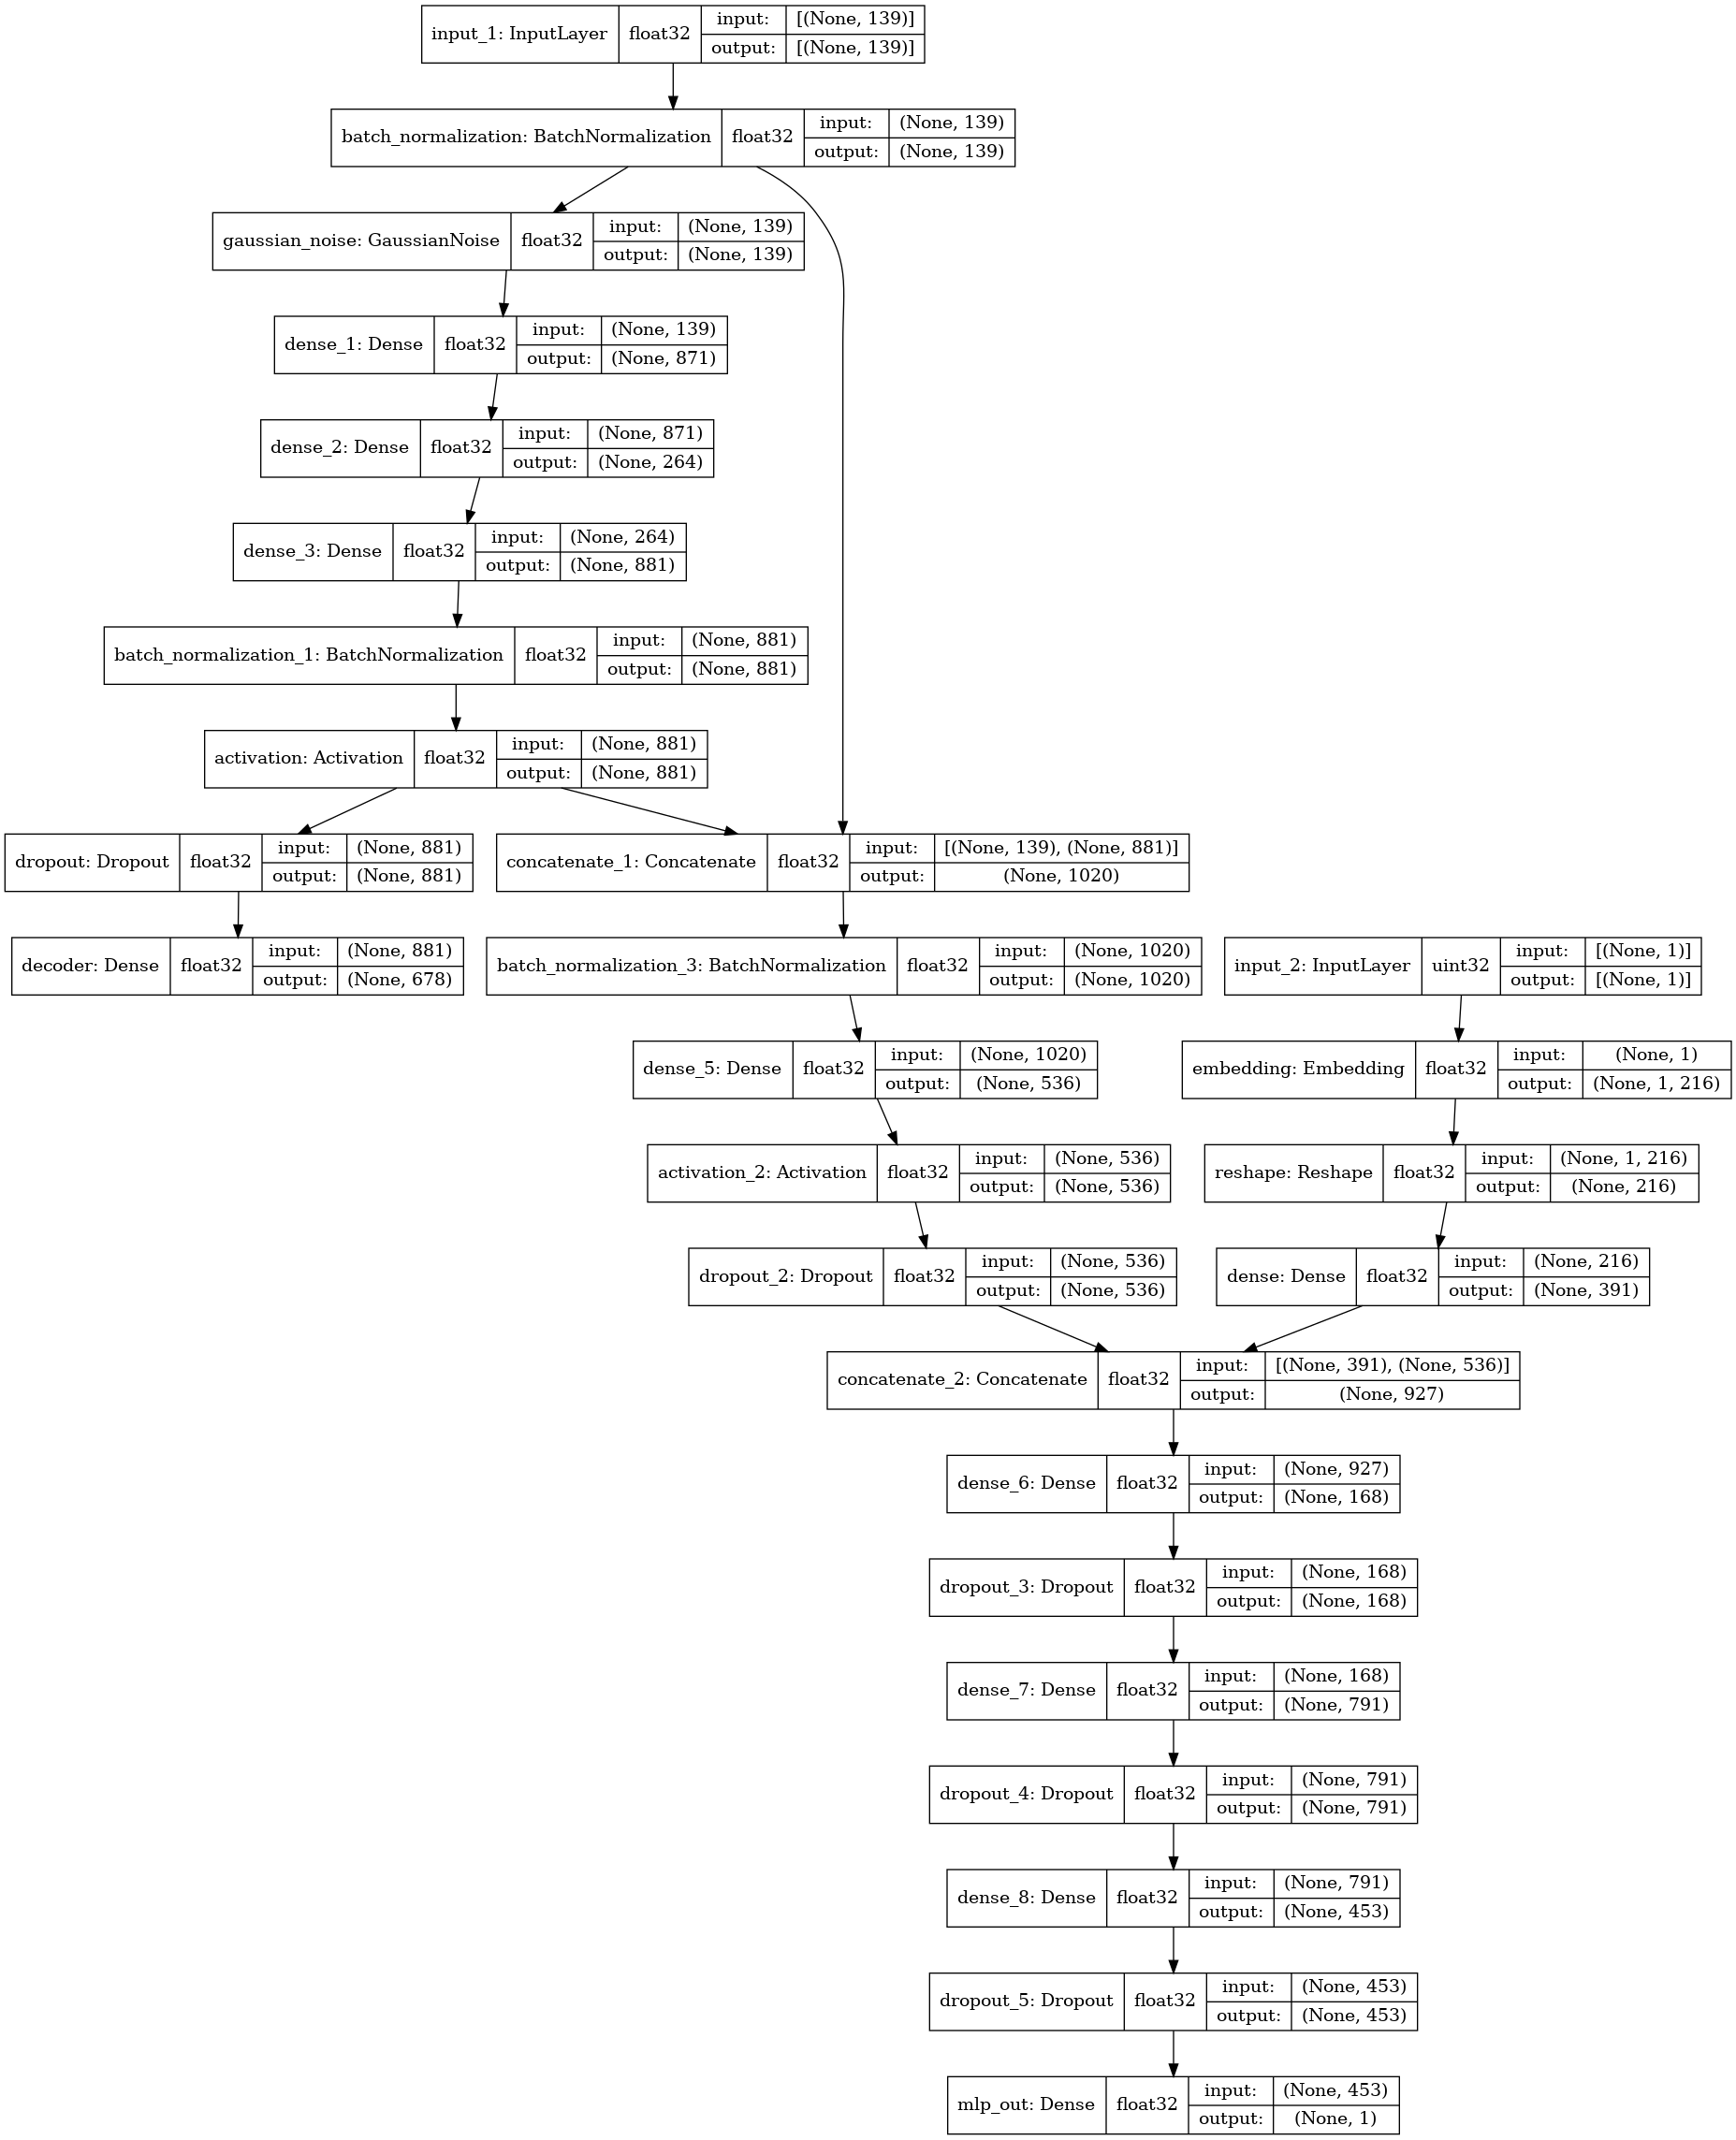

In [31]:
hp = pd.read_pickle('../input/hp-jpx-aemlp/hp_aempp_tf_139f_5f_tf.pkl')
tf.keras.utils.plot_model(build_model(hp), show_shapes=True, expand_nested=True, show_dtype=True)

In [32]:
def get_lr_callback(batch_size = 8):
    lr_start   = 3e-3
    lr_max     = 1.25e-10 * REPLICAS * batch_size
    lr_min     = 3e-12
    lr_ramp_ep = 3
    lr_sus_ep  = 0
    lr_decay   = 0.98
    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        else: lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

Epoch 1/100
499/499 [==============================] - 164s 322ms/step - loss: 4.6775 - decoder_loss: -0.3415 - mlp_out_loss: 0.4610 - decoder_cosine: 0.3412 - decoder_mae: 9.1410 - decoder_correlation: 0.6561 - decoder_rmse: 13.6807 - mlp_out_cosine: 0.0112 - mlp_out_mae: 0.0965 - mlp_out_correlation: 0.9927 - mlp_out_rmse: 0.6790 - val_loss: 1.1419 - val_decoder_loss: -0.4294 - val_mlp_out_loss: 9.3578e-04 - val_decoder_cosine: 0.4295 - val_decoder_mae: 12.1804 - val_decoder_correlation: 0.5893 - val_decoder_rmse: 16.4938 - val_mlp_out_cosine: 0.0269 - val_mlp_out_mae: 0.0231 - val_mlp_out_correlation: 1.0257 - val_mlp_out_rmse: 0.0306
Epoch 2/100
499/499 [==============================] - 14s 27ms/step - loss: 0.5632 - decoder_loss: -0.4314 - mlp_out_loss: 0.0019 - decoder_cosine: 0.4311 - decoder_mae: 16.4677 - decoder_correlation: 0.5662 - decoder_rmse: 22.6658 - mlp_out_cosine: 0.0755 - mlp_out_mae: 0.0326 - mlp_out_correlation: 0.9300 - mlp_out_rmse: 0.0440 - val_loss: 0.1257 - 

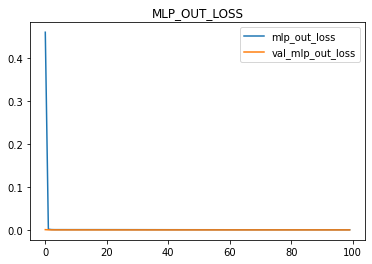

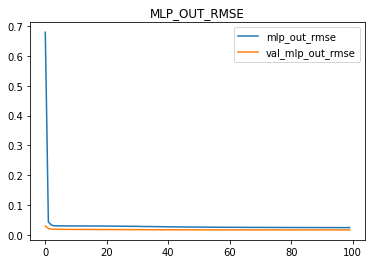

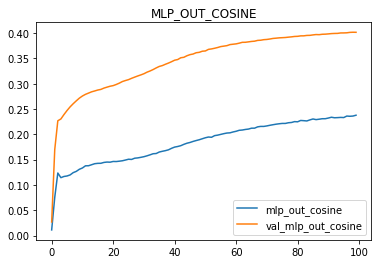

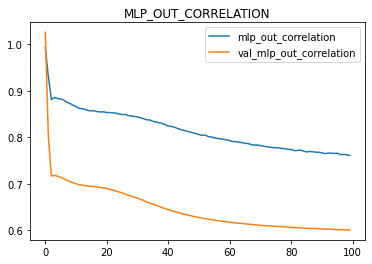

2022-06-14 06:47:58.467068: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1339247976 exceeds 10% of free system memory.


Pearson Score: 0.4048013566768961
Epoch 1/100
496/496 [==============================] - 143s 283ms/step - loss: -0.0611 - decoder_loss: -0.4095 - mlp_out_loss: 0.0178 - decoder_cosine: 0.4093 - decoder_mae: 2.6270 - decoder_correlation: 0.5890 - decoder_rmse: 3.8465 - mlp_out_cosine: 0.0923 - mlp_out_mae: 0.0379 - mlp_out_correlation: 0.9098 - mlp_out_rmse: 0.1333 - val_loss: -0.4923 - val_decoder_loss: -0.5050 - val_mlp_out_loss: 5.9518e-04 - val_decoder_cosine: 0.5051 - val_decoder_mae: 2.9658 - val_decoder_correlation: 0.5253 - val_decoder_rmse: 3.9519 - val_mlp_out_cosine: 0.2218 - val_mlp_out_mae: 0.0163 - val_mlp_out_correlation: 0.6202 - val_mlp_out_rmse: 0.0244
Epoch 2/100
496/496 [==============================] - 8s 15ms/step - loss: -0.4594 - decoder_loss: -0.4642 - mlp_out_loss: 5.4767e-04 - decoder_cosine: 0.4640 - decoder_mae: 3.6921 - decoder_correlation: 0.5334 - decoder_rmse: 5.1266 - mlp_out_cosine: 0.0530 - mlp_out_mae: 0.0156 - mlp_out_correlation: 0.9801 - mlp_out

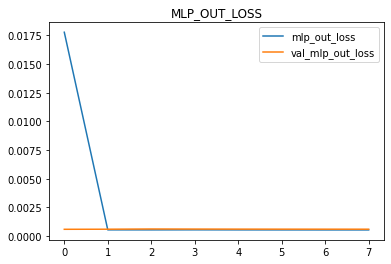

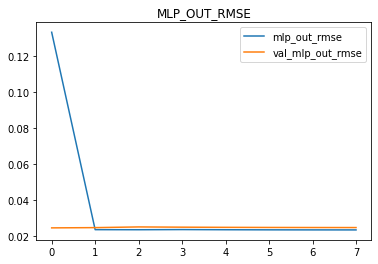

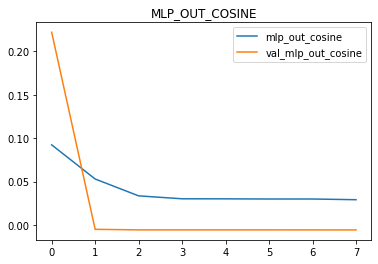

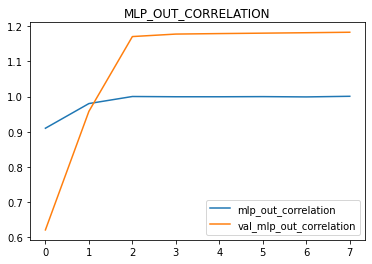

2022-06-14 06:51:31.958126: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1092418260 exceeds 10% of free system memory.


Pearson Score: 0.4089878504538345
Epoch 1/100
494/494 [==============================] - 146s 291ms/step - loss: 3.0768 - decoder_loss: -0.3915 - mlp_out_loss: 0.1332 - decoder_cosine: 0.3911 - decoder_mae: 13.6940 - decoder_correlation: 0.6087 - decoder_rmse: 20.3827 - mlp_out_cosine: 0.0274 - mlp_out_mae: 0.0351 - mlp_out_correlation: 0.9793 - mlp_out_rmse: 0.3649 - val_loss: 0.1718 - val_decoder_loss: -0.4950 - val_mlp_out_loss: 5.8762e-04 - val_decoder_cosine: 0.4959 - val_decoder_mae: 17.4478 - val_decoder_correlation: 0.5309 - val_decoder_rmse: 22.7380 - val_mlp_out_cosine: 0.2385 - val_mlp_out_mae: 0.0158 - val_mlp_out_correlation: 0.7806 - val_mlp_out_rmse: 0.0242
Epoch 2/100
494/494 [==============================] - 15s 30ms/step - loss: -0.1134 - decoder_loss: -0.4845 - mlp_out_loss: 0.0011 - decoder_cosine: 0.4838 - decoder_mae: 21.3784 - decoder_correlation: 0.5144 - decoder_rmse: 29.9753 - mlp_out_cosine: 0.0764 - mlp_out_mae: 0.0243 - mlp_out_correlation: 0.9297 - mlp_ou

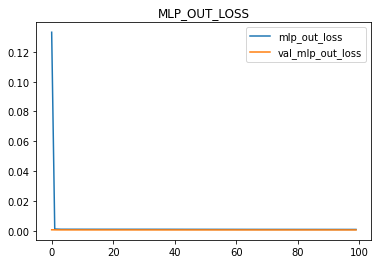

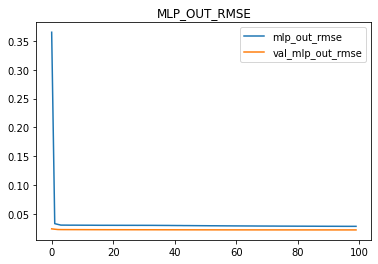

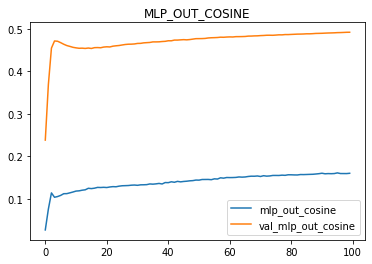

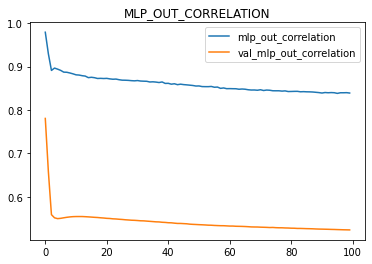

Pearson Score: 0.4748554372665823
Epoch 1/100
491/491 [==============================] - 172s 346ms/step - loss: 5.3659 - decoder_loss: -0.3313 - mlp_out_loss: 0.2827 - decoder_cosine: 0.3311 - decoder_mae: 2.3529 - decoder_correlation: 0.6669 - decoder_rmse: 3.5499 - mlp_out_cosine: 0.0608 - mlp_out_mae: 0.1372 - mlp_out_correlation: 0.9411 - mlp_out_rmse: 0.5317 - val_loss: 0.5596 - val_decoder_loss: -0.4815 - val_mlp_out_loss: 5.7917e-04 - val_decoder_cosine: 0.4814 - val_decoder_mae: 2.9289 - val_decoder_correlation: 0.5406 - val_decoder_rmse: 4.2542 - val_mlp_out_cosine: 0.3332 - val_mlp_out_mae: 0.0166 - val_mlp_out_correlation: 0.6875 - val_mlp_out_rmse: 0.0241
Epoch 2/100
491/491 [==============================] - 11s 22ms/step - loss: 0.1518 - decoder_loss: -0.4279 - mlp_out_loss: 6.9276e-04 - decoder_cosine: 0.4276 - decoder_mae: 3.9257 - decoder_correlation: 0.5697 - decoder_rmse: 5.4939 - mlp_out_cosine: 0.2231 - mlp_out_mae: 0.0182 - mlp_out_correlation: 0.7754 - mlp_out_r

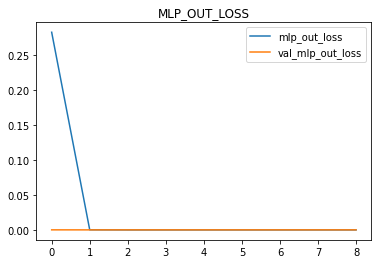

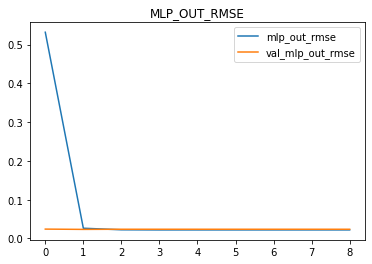

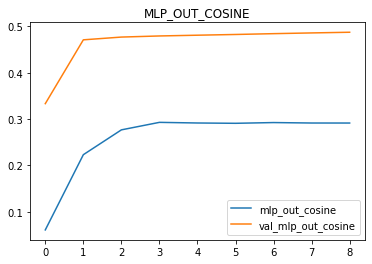

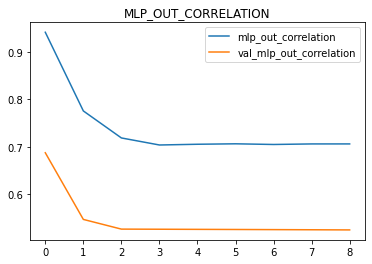

2022-06-14 07:28:40.625178: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1622314912 exceeds 10% of free system memory.


Pearson Score: 0.4457660962642853
Epoch 1/100
496/496 [==============================] - 163s 320ms/step - loss: 0.7820 - decoder_loss: -0.4144 - mlp_out_loss: 0.0729 - decoder_cosine: 0.4144 - decoder_mae: 5.0402 - decoder_correlation: 0.5836 - decoder_rmse: 7.6203 - mlp_out_cosine: 0.1543 - mlp_out_mae: 0.0616 - mlp_out_correlation: 0.8489 - mlp_out_rmse: 0.2700 - val_loss: -0.3320 - val_decoder_loss: -0.5013 - val_mlp_out_loss: 4.4355e-04 - val_decoder_cosine: 0.4986 - val_decoder_mae: 8.4103 - val_decoder_correlation: 0.5232 - val_decoder_rmse: 13.2285 - val_mlp_out_cosine: 0.4099 - val_mlp_out_mae: 0.0146 - val_mlp_out_correlation: 0.5956 - val_mlp_out_rmse: 0.0211
Epoch 2/100
496/496 [==============================] - 11s 22ms/step - loss: -0.4045 - decoder_loss: -0.4911 - mlp_out_loss: 5.4421e-04 - decoder_cosine: 0.4911 - decoder_mae: 7.2476 - decoder_correlation: 0.5058 - decoder_rmse: 10.0980 - mlp_out_cosine: 0.2539 - mlp_out_mae: 0.0159 - mlp_out_correlation: 0.7406 - mlp_o

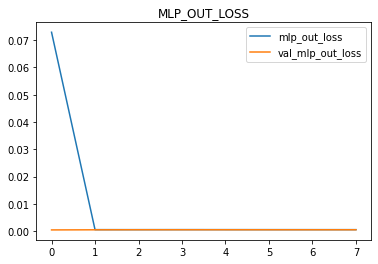

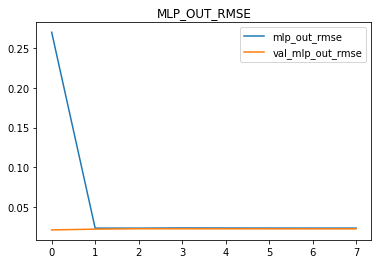

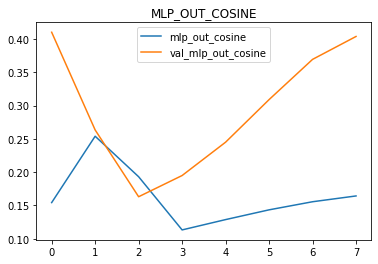

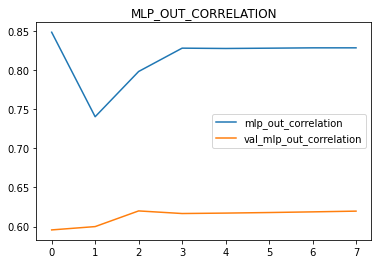

2022-06-14 07:34:07.972232: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1784878336 exceeds 10% of free system memory.


Pearson Score: 0.4196490012167191
CPU times: user 54min 44s, sys: 9min, total: 1h 3min 45s
Wall time: 1h 18min 30s


In [33]:
%%time
gc.collect()
models = []

fold = [0,1,2,3,4]
for i in range(len(fold)):
    train_path = f"../input/jpx-cgkf-f98-tf/fold_{fold[i]}_train.tfrecords"
    valid_path = f"../input/jpx-cgkf-f98-tf/fold_{fold[i]}_test.tfrecords"
    valid_ds   = make_dataset([valid_path], mode="valid")
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_{fold[i]}.tf", monitor="val_mlp_out_loss", mode="min", save_best_only=True, save_weights_only=True)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mlp_out_loss', patience=7, mode='min', restore_best_weights=True)
    K.clear_session()
    with strategy.scope(): model = build_model(hp, dim=feat.shape[-1], fold=fold[i])
    if config.is_training:
        train_ds = make_dataset([train_path])
        history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=[checkpoint, 
                                                                                       early_stop,
                                                                                       get_lr_callback(batch_size = 4096*REPLICAS)])
        gc.collect()
        model.load_weights(f"model_{fold[i]}.tf")
        
        for metric in ["mlp_out_loss", "mlp_out_rmse", "mlp_out_cosine", "mlp_out_correlation"]:
            pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
            gc.collect()
        
    else:
        model.load_weights(f"{config.output_dataset_path}model_{fold[i]}.tf")
    y_vals = []
    for _, y in valid_ds:
        y_vals += list(y.numpy().reshape(-1))
    y_val = np.array(y_vals)
    pearson_score = stats.pearsonr((model.predict(valid_ds)[-1].reshape(-1)), y_val)[0]
    models.append(model)
    print(f"Pearson Score: {pearson_score}")
    gc.collect()

In [34]:
def preprocess_test(securities_code, feature):
    return (securities_code, feature), 0

def make_test_dataset(feature, securities_code, batch_size=4096*REPLICAS):
    ds = tf.data.Dataset.from_tensor_slices(((securities_code, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)[-1].reshape(-1)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [35]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()   # initialize the environment
iter_test = env.iter_test()                   # an iterator which loops over the test files
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    prices_df                        = get_features(prices, tr=False)
    sample_prediction["Prediction"]  = inference(models, make_test_dataset(prices_df[feat], prices['SecuritiesCode']))
    sample_prediction["rate"]        = sample_prediction["Prediction"]
    sample_prediction.sort_values(by = "rate", ascending=False, inplace=True)
    sample_prediction.Rank           = np.arange(0,2000)
    sample_prediction.sort_values(by = "SecuritiesCode", ascending=True, inplace=True)
    submission                       = sample_prediction[["Date","SecuritiesCode","Rank"]]
    display(submission)
    env.predict(submission)  

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,Date,SecuritiesCode,Rank
0,2021-12-06,1301,1152
1,2021-12-06,1332,1150
2,2021-12-06,1333,1175
3,2021-12-06,1375,1162
4,2021-12-06,1376,1217
...,...,...,...
1995,2021-12-06,9990,15
1996,2021-12-06,9991,29
1997,2021-12-06,9993,147
1998,2021-12-06,9994,308


,Date,SecuritiesCode,Rank
0,2021-12-07,1301,1158
1,2021-12-07,1332,1154
2,2021-12-07,1333,1182
3,2021-12-07,1375,1176
4,2021-12-07,1376,1224
...,...,...,...
1995,2021-12-07,9990,15
1996,2021-12-07,9991,31
1997,2021-12-07,9993,138
1998,2021-12-07,9994,306


# PREVIOUS LEVEL
* [JPX(0/2): AEMLP-GKF: Natapong Nitarach](https://www.kaggle.com/code/natnitarach/jpx-aemlp-gkf)

# NEXT LEVEL
* [JPX(2/2): LSTM+GRU-TF: Natapong Nitarach](https://www.kaggle.com/natnitarach/jpx-2-2-lstm-gru-tf/)

# CHANGE UNIVERSE
* [Crypto Forecasting(1/1) : SAEMLP-QHO: Natapong Nitarach](https://www.kaggle.com/code/natnitarach/crypto-forecasting-1-1-saemlp-qho?scriptVersionId=87744356)